### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'
#data_root = '/media/scottcha/E1/Data/Temp/Tutorial/'
ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1

In [4]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:1000,feature,:])

In [5]:
def calculate_feature_std(feature):
    print('On feature: ' + str(feature))
    return np.nanstd(X[0:1000,feature,:])

In [6]:
#load the X train data from numpy as memmapped file
X = np.load(ml_path + '/Xtrain_batch_0_windslab_on_disk.npy', mmap_mode='r')

In [7]:
#if we don't have cached versions of these we need to calcualte this for the feature
#standardization, this takes awhile and requires a lot of memory so I only do it on a subset
#of the data (first 100000 rows)
feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))

In [8]:
feature_std = Parallel(n_jobs=4)(map(delayed(calculate_feature_std), range(0,num_features)))

In [9]:
#cache the values
np.save(ml_path + '/feature_means_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_means))

In [10]:
np.save(ml_path + '/feature_std_interpolation' + str(interpolation) +  'x.npy', np.asarray(feature_std))

In [11]:
#load the values
feature_means = np.load(ml_path + '/feature_means_interpolation1x.npy')

In [12]:
feature_means[:10]

array([1.0549140e-04, 1.3265404e-04, 7.9789555e-05, 1.0935744e-04,
       1.2168142e-04, 9.7050535e-05, 1.0322270e-04, 1.1120097e-04,
       9.5369040e-05, 1.1347191e-04], dtype=float32)

In [13]:
feature_std = np.load(ml_path + '/feature_std_interpolation1x.npy')

In [14]:
feature_std[:10]

array([3.8507096e-05, 4.7568225e-05, 4.3321921e-05, 1.6923625e-05,
       1.8924302e-05, 1.8549199e-05, 2.4055355e-05, 2.4446805e-05,
       2.5227388e-05, 2.4972225e-05], dtype=float32)

In [15]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_windslab.npy', mmap_mode='r')

In [16]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_y_batches = 1
num_y_train_files_per_batch = 20
num_y_test_batches = 1
num_y_test_files_per_batch = 5
file_label = 'windslab'

y_df = None
for i in range(0, num_y_batches):
    for j in range(0, num_y_train_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

for i in range(0, num_y_test_batches):
    for j in range(0, num_y_test_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

In [17]:
y_df[y_df['season']!='19-20']['WindSlab_Likelihood'].value_counts()

1-possible       2729
no-data          2720
2-likely         2709
0-unlikely       2244
3-very likely    2098
Name: WindSlab_Likelihood, dtype: int64

In [18]:
y_df['season'].value_counts()

17-18    3677
16-17    3663
15-16    2660
18-19    2500
Name: season, dtype: int64

In [18]:
#cache the labels 
pickle.dump( y_df, open( ml_path + 'y_df.p', 'wb' ) )

In [19]:
y_df = pickle.load( open( ml_path + 'y_df.p', 'rb' ) )

In [20]:
y_df.shape

(12500, 303)

In [21]:
X.shape

(12500, 978, 180)

In [19]:
y_df['WindSlab_Likelihood'].value_counts()

1-possible       2729
no-data          2720
2-likely         2709
0-unlikely       2244
3-very likely    2098
Name: WindSlab_Likelihood, dtype: int64

In [20]:
y_df['WindSlab_Likelihood'].value_counts()

1-possible       2729
no-data          2720
2-likely         2709
0-unlikely       2244
3-very likely    2098
Name: WindSlab_Likelihood, dtype: int64

In [24]:
y_df[y_df['season']=='18-19']['WindSlab_Likelihood'].value_counts()

1-possible       729
no-data          720
2-likely         709
0-unlikely       244
3-very likely     98
Name: WindSlab_Likelihood, dtype: int64

In [26]:
#convert the labels to encoded values
y_df['Day1Windslab'] = y_df['WindSlab_Likelihood'].astype('category')
y = y_df['Day1Windslab'].cat.codes.values

In [28]:
pd.Series(y).value_counts()

1    2729
4    2720
2    2709
0    2244
3    2098
dtype: int64

In [61]:
y_df['Day1Windslab'][:10]

0       1-possible
1       1-possible
2    3-very likely
3    3-very likely
4    3-very likely
5    3-very likely
6       1-possible
7         2-likely
8       1-possible
9    3-very likely
Name: Day1Windslab, dtype: category
Categories (5, object): ['0-unlikely', '1-possible', '2-likely', '3-very likely', 'no-data']

In [60]:
y_df['Day1Windslab'].cat.codes.head(10)

0    1
1    1
2    3
3    3
4    3
5    3
6    1
7    2
8    1
9    3
dtype: int8

In [30]:
y[:10]

array([1, 1, 3, 3, 3, 3, 1, 2, 1, 3], dtype=int8)

In [31]:
#X_size=25000

In [32]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 10000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]), L([i for i in range(train_test_split,train_test_split+2500)]))

In [33]:
splits_2

((#10000) [0,1,2,3,4,5,6,7,8,9...],
 (#2500) [10000,10001,10002,10003,10004,10005,10006,10007,10008,10009...])

In [34]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [35]:
np.isnan(feature_means).any()

False

In [36]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [37]:
np.isnan(feature_std).any()

False

In [38]:
#method to standardize each batch while also replacing any nans with the mean value before standarization
class TSStandardizeNanMeanReplaceNan(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
       
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [39]:
X.shape

(12500, 978, 180)

In [40]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [41]:
X[0]

memmap([[          nan,           nan,           nan, ..., 9.6714291e-05,
         1.0285714e-04, 1.1214286e-04],
        [          nan,           nan,           nan, ..., 1.1400000e-04,
         1.2600000e-04, 1.4800001e-04],
        [          nan,           nan,           nan, ..., 8.5000000e-05,
         8.7000000e-05, 7.2000003e-05],
        ...,
        [          nan,           nan,           nan, ..., 2.8500000e-02,
         2.8500000e-02, 2.8500000e-02],
        [          nan,           nan,           nan, ..., 2.8500000e-02,
         2.8500000e-02, 2.8500000e-02],
        [          nan,           nan,           nan, ..., 2.8500000e-02,
         2.8500000e-02, 2.8500000e-02]], dtype=float32)

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/torch_core.py:117: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(x)


<AxesSubplot:title={'center':'2'}>

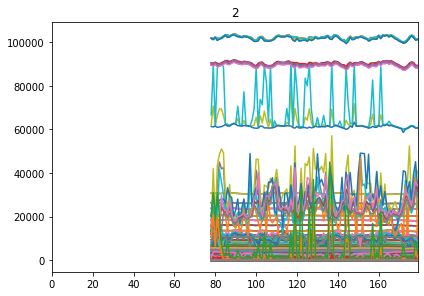

In [42]:
#check on set
show_at(dsets.valid, 6)

In [43]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[128], batch_tfms=[TSStandardizeNanMeanReplaceNan()], num_workers=0)

In [44]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

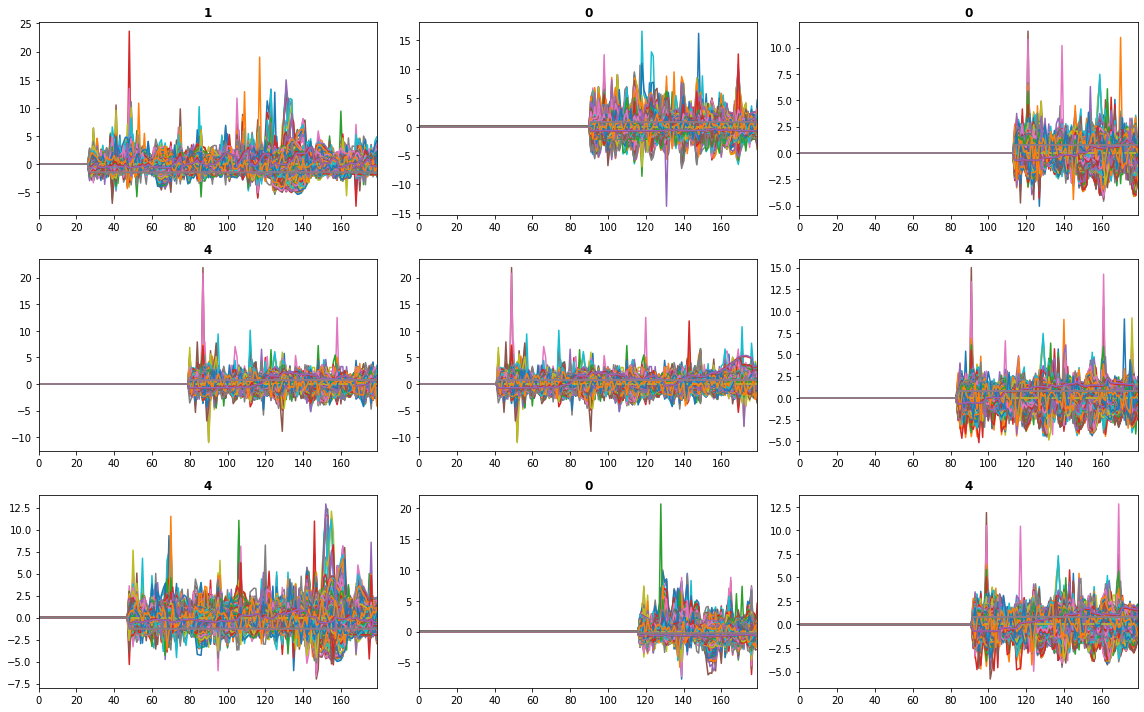

In [45]:
dls.show_batch()

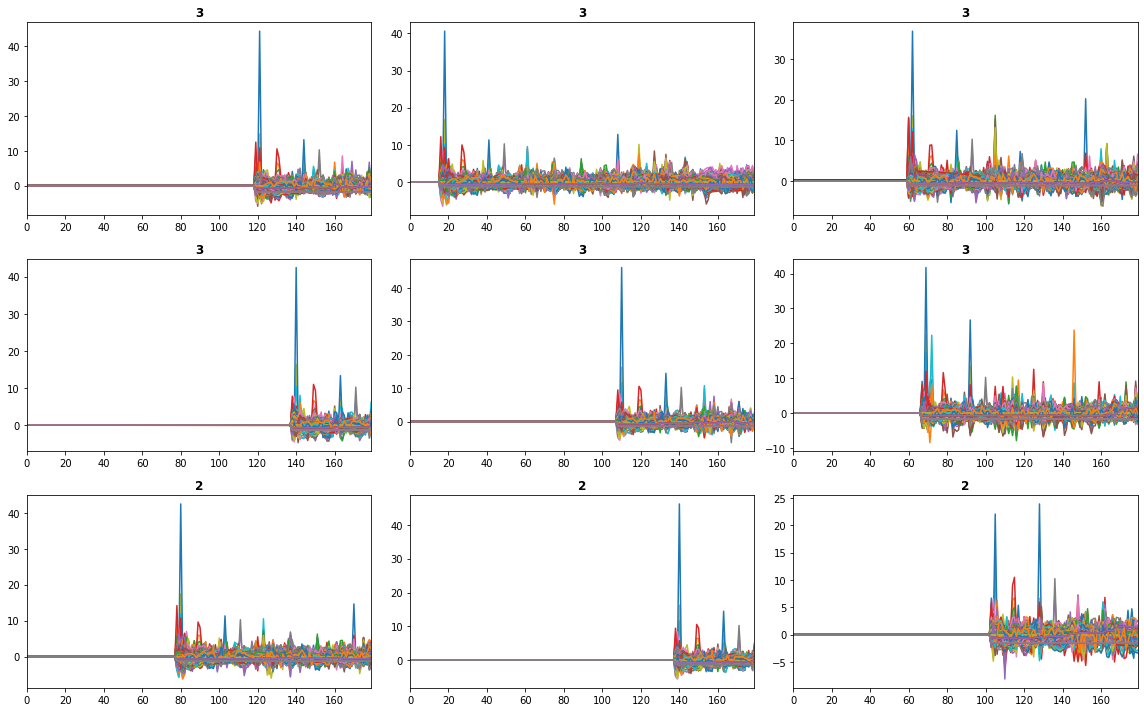

In [46]:
dls.valid.show_batch()

In [47]:
dls.c

5

In [48]:
dls.vars

978

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [49]:
dls.valid.c

5

In [54]:
model = InceptionTime(dls.vars, dls.c)
matcor = MatthewsCorrCoef()

#learn = Learner(dls, model, metrics=[matcor, accuracy])
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=9.12010818865383e-07)

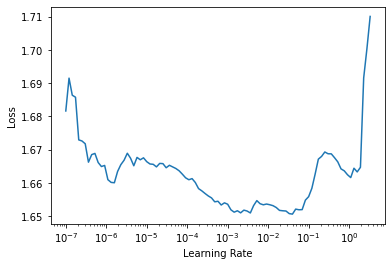

In [55]:
learn.load('stage0')
learn.lr_find()

In [52]:
#learn.fit(n_epoch=10, lr=1e-2)

In [56]:
#can use this once overfitting is resolved
learn.fit_one_cycle(3, lr_max=1e-2)
#learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,1.640020,nan,0.289600,01:32
1,1.623509,nan,0.189200,01:34
2,1.613014,nan,0.227600,01:37


### Results
1. looking at the metrics above it seems to be overfitting after epoch 1
2. Looking at the confusion matrix we can see that its ok at distinquishing between 0/1 & 2/3 

Possibilities:
2. There may be features which are causing the overfitting


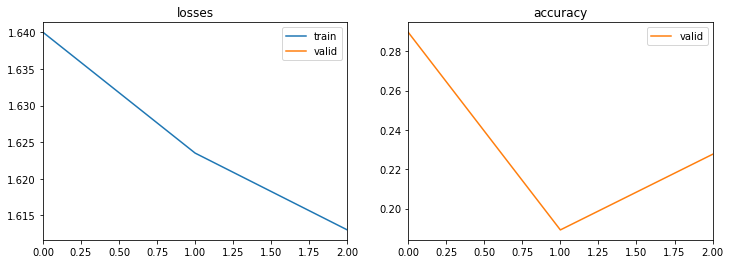

In [57]:
#only works with more than one epoch
learn.recorder.plot_metrics()

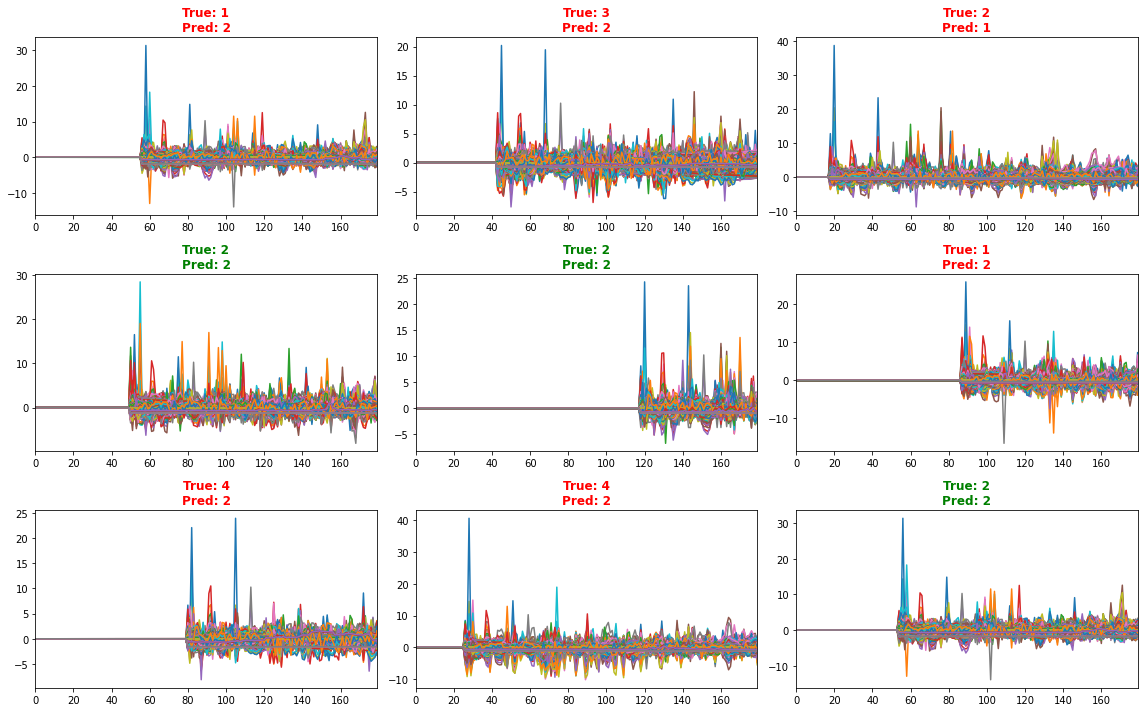

In [58]:
learn.show_results()

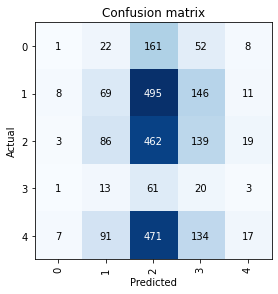

In [59]:
#confustion matrix, not very good, more work to do . . . but the only goal of this notebook was to illustrate the 
#end to end process.  
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()